In [1]:
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./

!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 590862, done.
remote: Counting objects: 100% (1217/1217), done.
remote: Compressing objects: 100% (926/926), done.
remote: Total 590862 (delta 980), reused 335 (delta 285), pack-reused 589645 (from 5)
Receiving objects: 100% (590862/590862), 1.12 GiB | 39.80 MiB/s, done.
Resolving deltas: 100% (552019/552019), done.
fatal: not a git repository (or any parent up to mount point /kaggle)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [2]:
import os
import shutil
from pathlib import Path
import logging
import random
import warnings
import time
import io
import sys

# Data handling and transformations
import numpy as np
from PIL import Image
import cv2
import xml.etree.ElementTree as ET

# Machine learning and deep learning libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

# For image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# Progress bar
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches 

# Custom libraries
import utils
import transforms as T
import engine  # Assuming this is a custom library
import logging
from engine import train_one_epoch, evaluate
from torchvision import models, transforms

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
# Define paths
TRAIN_IMAGES_DIR = "/kaggle/input/cs406-data/enhance_dce_denoise/train/images"
VAL_IMAGES_DIR = "/kaggle/input/cs406-data/enhance_dce_denoise/val/images"
TEST_IMAGES_DIR = "/kaggle/input/cs406-data/enhance_dce_denoise/test/images"
ANNOTATIONS_DIR = "/kaggle/input/cs406-data/enhance_dce_denoise/VOC_Annotations"


In [4]:
class VehicleDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, annotations_dir, transforms=None):
        self.images_dir = images_dir
        self.transforms = transforms
        self.annotations_dir = annotations_dir
        self.image_files = [f for f in os.listdir(images_dir) ]
        

    def __len__(self):
        return len(self.image_files)
        
    def __getitem__(self, idx):
        image_filename = self.image_files[idx]
        image_path = os.path.join(self.images_dir, image_filename)
        anno_file =  os.path.splitext(image_filename)[0] + ".xml"
        annotation_path = os.path.join(self.annotations_dir,anno_file)
        img = Image.open(image_path).convert("RGB")
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        boxes = []
        labels = []
        img_width, img_height = img.size
        for obj in root.findall("object"):
            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)
            boxes.append([xmin, ymin, xmax, ymax])
            name = obj.find("name").text
            label = int(name.split('_')[-1]) 
            labels.append(label)
        if len(boxes) == 0:
            return None, None
            
        # Convert boxes to numpy array for albumentations (no manual normalization here)
        boxes = np.array(boxes, dtype=np.float32)
        
        # Apply transformations if provided
        if self.transforms:
            img = self.transforms(img)

        # Convert boxes to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Calculate area of each box
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # Suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        # Prepare the target dictionary
        target = {
            "boxes": boxes,
            "labels": labels,
            "area": area,
            "iscrowd": iscrowd,
            "image_id": int(idx)
        }

        return img, target

torch.Size([3, 640, 640]) 
 {'boxes': tensor([[211., 262., 449., 422.],
        [323.,   6., 463., 264.]]), 'labels': tensor([2, 2]), 'area': tensor([38080., 36120.]), 'iscrowd': tensor([0, 0]), 'image_id': 25}


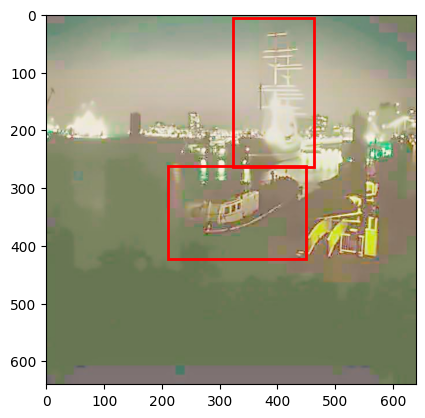

In [5]:
tmp_dataset = VehicleDataset(TRAIN_IMAGES_DIR, ANNOTATIONS_DIR)
# ========================
# Plot Image with Bounding Boxes
# ========================
def plot_img_bbox(img, target):
    fig, ax = plt.subplots(1, 1)
    ax.imshow(img.permute(1, 2, 0))  # Convert to HxWxC format for plotting
    for box in target['boxes']:
        x_min, y_min, x_max, y_max = box
        width = x_max - x_min
        height = y_max - y_min
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()
transform = transforms.Compose([
    transforms.ToTensor(),
])
tmp_dataset = VehicleDataset(TRAIN_IMAGES_DIR, ANNOTATIONS_DIR, transform)
img, target = tmp_dataset[25]
print(img.shape, '\n', target)
plot_img_bbox(img, target)

In [6]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Chuyển ảnh PIL -> Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Chuẩn hóa 3 kênh RGB
])
# Define dataset and dataloader
train_dataset = VehicleDataset(TRAIN_IMAGES_DIR, ANNOTATIONS_DIR, transform)
train_dataloader =  torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*[(img, tgt) for img, tgt in x if img is not None and tgt is not None])))
# Validation setup
val_dataset = VehicleDataset(VAL_IMAGES_DIR, ANNOTATIONS_DIR, transform)
val_dataloader =  torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*[(img, tgt) for img, tgt in x if img is not None and tgt is not None])))
# Test setup
test_dataset = VehicleDataset(TEST_IMAGES_DIR, ANNOTATIONS_DIR,transform)
test_dataloader =  torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*[(img, tgt) for img, tgt in x if img is not None and tgt is not None])))

In [7]:
from pathlib import Path

LOG_FILE = "/kaggle/working/results/log.txt"
ERROR_FILE = "/kaggle/working/results/error.txt"

Path(LOG_FILE).parent.mkdir(parents=True, exist_ok=True)
Path(ERROR_FILE).parent.mkdir(parents=True, exist_ok=True)

logger = logging.getLogger()
logger.setLevel(logging.INFO)  # Ensure logger level is set to INFO or DEBUG
formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")

# File handler to log to the log.txt file
file_handler = logging.FileHandler(LOG_FILE, mode='w')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

# Stream handler to log to terminal
stream_handler = logging.StreamHandler()
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)


In [8]:
def get_model(num_classes):
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    print("Model Done!")
    return model

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = get_model(6)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
num_epochs = 20

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 218MB/s]


Model Done!


In [10]:
import torch

# Directory for saving checkpoints
CHECKPOINT_DIR = "/kaggle/working/results/checkpoints/"
Path(CHECKPOINT_DIR).mkdir(parents=True, exist_ok=True)

def save_checkpoint(model, optimizer, epoch, checkpoint_dir=CHECKPOINT_DIR):
    checkpoint_path = Path(checkpoint_dir) / f"checkpoint_epoch_{epoch}.pth"
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch}")
    logger.info(f"Checkpoint saved at epoch {epoch}")

# Initialize variables for tracking the best performance
best_metric = float('-inf')  # Or float('inf') if you're using a loss function and minimizing it

# Training loop with checkpoint saving
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_dataloader, device, epoch, print_freq=20)
    metric = evaluate(model, val_dataloader, device)  # e.g., validation accuracy or validation loss
    logger.info(f"Evaluation results on validation set: {metric}")
    print(metric)

    # Save checkpoint at the end of each epoch
    save_checkpoint(model, optimizer, epoch)


print('===== Evaluate on Test =====')
logger.info("Starting evaluation on test set...")
result = evaluate(model, test_dataloader, device)
print()
logger.info(f"Evaluation results on test set: {result}")


/kaggle/working/engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [  0/263]  eta: 0:10:13  lr: 0.000000  loss: 2.2655 (2.2655)  loss_classifier: 1.8074 (1.8074)  loss_box_reg: 0.0634 (0.0634)  loss_objectness: 0.3701 (0.3701)  loss_rpn_box_reg: 0.0246 (0.0246)  time: 2.3342  data: 0.1256  max mem: 5805
Epoch: [0]  [ 20/263]  eta: 0:03:59  lr: 0.000008  loss: 1.6181 (1.6102)  loss_classifier: 1.3014 (1.2923)  loss_box_reg: 0.0845 (0.0873)  loss_objectness: 0.1603 (0.2100)  loss_rpn_box_reg: 0.0188 (0.0206)  time: 0.9167  data: 0.1298  max mem: 6120
Epoch: [0]  [ 40/263]  eta: 0:03:31  lr: 0.000016  loss: 0.5976 (1.0934)  loss_classifier: 0.2879 (0.7967)  loss_box_reg: 0.1603 (0.1229)  loss_objectness: 0.0721 (0.1544)  loss_rpn_box_reg: 0.0171 (0.0194)  time: 0.9098  data: 0.1202  max mem: 6120
Epoch: [0]  [ 60/263]  eta: 0:03:09  lr: 0.000023  loss: 0.3901 (0.8722)  loss_classifier: 0.1951 (0.6016)  loss_box_reg: 0.1285 (0.1302)  loss_objectness: 0.0481 (0.1239)  loss_rpn_box_reg: 0.0102 (0.0165)  time: 0.9058  data: 0.1145  max mem: 6120


2024-12-26 01:04:30,481 - INFO - Evaluation results on validation set: <coco_eval.CocoEvaluator object at 0x7827902238b0>


DONE (t=0.61s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.114
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.298
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.073
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.020
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.052
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.141
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.150
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.283
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.315
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.058
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.184
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.357


2024-12-26 01:04:31,426 - INFO - Checkpoint saved at epoch 0


Checkpoint saved at epoch 0
Epoch: [1]  [  0/263]  eta: 0:03:44  lr: 0.000100  loss: 0.4166 (0.4166)  loss_classifier: 0.2112 (0.2112)  loss_box_reg: 0.1711 (0.1711)  loss_objectness: 0.0278 (0.0278)  loss_rpn_box_reg: 0.0066 (0.0066)  time: 0.8539  data: 0.0576  max mem: 6120
Epoch: [1]  [ 20/263]  eta: 0:03:28  lr: 0.000100  loss: 0.3155 (0.3481)  loss_classifier: 0.1489 (0.1626)  loss_box_reg: 0.1408 (0.1536)  loss_objectness: 0.0210 (0.0238)  loss_rpn_box_reg: 0.0066 (0.0081)  time: 0.8592  data: 0.0631  max mem: 6120
Epoch: [1]  [ 40/263]  eta: 0:03:11  lr: 0.000100  loss: 0.3327 (0.3290)  loss_classifier: 0.1405 (0.1505)  loss_box_reg: 0.1411 (0.1490)  loss_objectness: 0.0165 (0.0222)  loss_rpn_box_reg: 0.0068 (0.0074)  time: 0.8555  data: 0.0601  max mem: 6120
Epoch: [1]  [ 60/263]  eta: 0:02:53  lr: 0.000100  loss: 0.3672 (0.3395)  loss_classifier: 0.1641 (0.1550)  loss_box_reg: 0.1588 (0.1531)  loss_objectness: 0.0235 (0.0237)  loss_rpn_box_reg: 0.0079 (0.0078)  time: 0.8511  

2024-12-26 01:08:55,064 - INFO - Evaluation results on validation set: <coco_eval.CocoEvaluator object at 0x7827916f1cf0>


DONE (t=0.36s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.214
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.432
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.186
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.060
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.119
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.254
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.211
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.357
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.380
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.170
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.288
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.412


2024-12-26 01:08:55,820 - INFO - Checkpoint saved at epoch 1


Checkpoint saved at epoch 1
Epoch: [2]  [  0/263]  eta: 0:03:42  lr: 0.000100  loss: 0.1525 (0.1525)  loss_classifier: 0.0667 (0.0667)  loss_box_reg: 0.0689 (0.0689)  loss_objectness: 0.0118 (0.0118)  loss_rpn_box_reg: 0.0052 (0.0052)  time: 0.8476  data: 0.0549  max mem: 6120
Epoch: [2]  [ 20/263]  eta: 0:03:27  lr: 0.000100  loss: 0.2771 (0.2926)  loss_classifier: 0.1133 (0.1237)  loss_box_reg: 0.1351 (0.1454)  loss_objectness: 0.0132 (0.0162)  loss_rpn_box_reg: 0.0067 (0.0072)  time: 0.8535  data: 0.0577  max mem: 6120
Epoch: [2]  [ 40/263]  eta: 0:03:10  lr: 0.000100  loss: 0.2658 (0.2834)  loss_classifier: 0.1057 (0.1170)  loss_box_reg: 0.1312 (0.1452)  loss_objectness: 0.0094 (0.0141)  loss_rpn_box_reg: 0.0067 (0.0071)  time: 0.8544  data: 0.0578  max mem: 6120
Epoch: [2]  [ 60/263]  eta: 0:02:53  lr: 0.000100  loss: 0.2265 (0.2679)  loss_classifier: 0.0903 (0.1100)  loss_box_reg: 0.1276 (0.1381)  loss_objectness: 0.0082 (0.0131)  loss_rpn_box_reg: 0.0050 (0.0067)  time: 0.8568  

2024-12-26 01:13:18,912 - INFO - Evaluation results on validation set: <coco_eval.CocoEvaluator object at 0x78286b30a6b0>


DONE (t=0.25s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.252
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.469
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.245
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.043
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.128
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.300
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.247
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.369
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.379
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.109
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.247
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.425


2024-12-26 01:13:19,567 - INFO - Checkpoint saved at epoch 2


Checkpoint saved at epoch 2
Epoch: [3]  [  0/263]  eta: 0:03:42  lr: 0.000100  loss: 0.2171 (0.2171)  loss_classifier: 0.0807 (0.0807)  loss_box_reg: 0.1255 (0.1255)  loss_objectness: 0.0077 (0.0077)  loss_rpn_box_reg: 0.0032 (0.0032)  time: 0.8450  data: 0.0534  max mem: 6120
Epoch: [3]  [ 20/263]  eta: 0:03:29  lr: 0.000100  loss: 0.1821 (0.1866)  loss_classifier: 0.0656 (0.0690)  loss_box_reg: 0.0993 (0.1048)  loss_objectness: 0.0069 (0.0078)  loss_rpn_box_reg: 0.0046 (0.0049)  time: 0.8628  data: 0.0615  max mem: 6120
Epoch: [3]  [ 40/263]  eta: 0:03:11  lr: 0.000100  loss: 0.1729 (0.2020)  loss_classifier: 0.0719 (0.0765)  loss_box_reg: 0.0948 (0.1125)  loss_objectness: 0.0065 (0.0076)  loss_rpn_box_reg: 0.0052 (0.0055)  time: 0.8535  data: 0.0586  max mem: 6120
Epoch: [3]  [ 60/263]  eta: 0:02:54  lr: 0.000100  loss: 0.2041 (0.2091)  loss_classifier: 0.0767 (0.0778)  loss_box_reg: 0.1181 (0.1181)  loss_objectness: 0.0074 (0.0077)  loss_rpn_box_reg: 0.0051 (0.0056)  time: 0.8562  

2024-12-26 01:17:42,738 - INFO - Evaluation results on validation set: <coco_eval.CocoEvaluator object at 0x782790b6f250>


DONE (t=0.26s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.260
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.517
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.243
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.055
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.146
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.306
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.236
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.373
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.386
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.161
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.267
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.425


2024-12-26 01:17:43,367 - INFO - Checkpoint saved at epoch 3


Checkpoint saved at epoch 3
Epoch: [4]  [  0/263]  eta: 0:03:48  lr: 0.000100  loss: 0.1412 (0.1412)  loss_classifier: 0.0511 (0.0511)  loss_box_reg: 0.0757 (0.0757)  loss_objectness: 0.0114 (0.0114)  loss_rpn_box_reg: 0.0030 (0.0030)  time: 0.8699  data: 0.0691  max mem: 6120
Epoch: [4]  [ 20/263]  eta: 0:03:29  lr: 0.000100  loss: 0.1391 (0.1503)  loss_classifier: 0.0452 (0.0498)  loss_box_reg: 0.0819 (0.0899)  loss_objectness: 0.0043 (0.0058)  loss_rpn_box_reg: 0.0044 (0.0048)  time: 0.8607  data: 0.0607  max mem: 6120
Epoch: [4]  [ 40/263]  eta: 0:03:11  lr: 0.000100  loss: 0.1784 (0.1668)  loss_classifier: 0.0554 (0.0566)  loss_box_reg: 0.1078 (0.0993)  loss_objectness: 0.0046 (0.0061)  loss_rpn_box_reg: 0.0044 (0.0049)  time: 0.8546  data: 0.0586  max mem: 6120
Epoch: [4]  [ 60/263]  eta: 0:02:54  lr: 0.000100  loss: 0.1529 (0.1674)  loss_classifier: 0.0532 (0.0574)  loss_box_reg: 0.0942 (0.0997)  loss_objectness: 0.0037 (0.0056)  loss_rpn_box_reg: 0.0045 (0.0048)  time: 0.8597  

2024-12-26 01:22:06,729 - INFO - Evaluation results on validation set: <coco_eval.CocoEvaluator object at 0x7827916f1cf0>


2024-12-26 01:22:07,360 - INFO - Checkpoint saved at epoch 4


Checkpoint saved at epoch 4
Epoch: [5]  [  0/263]  eta: 0:03:46  lr: 0.000100  loss: 0.1193 (0.1193)  loss_classifier: 0.0388 (0.0388)  loss_box_reg: 0.0758 (0.0758)  loss_objectness: 0.0017 (0.0017)  loss_rpn_box_reg: 0.0031 (0.0031)  time: 0.8608  data: 0.0605  max mem: 6120
Epoch: [5]  [ 20/263]  eta: 0:03:28  lr: 0.000100  loss: 0.1495 (0.1566)  loss_classifier: 0.0479 (0.0521)  loss_box_reg: 0.0878 (0.0963)  loss_objectness: 0.0035 (0.0040)  loss_rpn_box_reg: 0.0037 (0.0042)  time: 0.8566  data: 0.0596  max mem: 6120
Epoch: [5]  [ 40/263]  eta: 0:03:11  lr: 0.000100  loss: 0.1513 (0.1600)  loss_classifier: 0.0557 (0.0547)  loss_box_reg: 0.0920 (0.0972)  loss_objectness: 0.0029 (0.0039)  loss_rpn_box_reg: 0.0037 (0.0042)  time: 0.8571  data: 0.0603  max mem: 6120
Epoch: [5]  [ 60/263]  eta: 0:02:53  lr: 0.000100  loss: 0.1285 (0.1524)  loss_classifier: 0.0422 (0.0516)  loss_box_reg: 0.0727 (0.0928)  loss_objectness: 0.0023 (0.0037)  loss_rpn_box_reg: 0.0034 (0.0042)  time: 0.8535  

2024-12-26 01:26:30,327 - INFO - Evaluation results on validation set: <coco_eval.CocoEvaluator object at 0x782790b00d00>


2024-12-26 01:26:31,111 - INFO - Checkpoint saved at epoch 5


Checkpoint saved at epoch 5
Epoch: [6]  [  0/263]  eta: 0:03:41  lr: 0.000100  loss: 0.1615 (0.1615)  loss_classifier: 0.0465 (0.0465)  loss_box_reg: 0.1085 (0.1085)  loss_objectness: 0.0030 (0.0030)  loss_rpn_box_reg: 0.0035 (0.0035)  time: 0.8436  data: 0.0518  max mem: 6120
Epoch: [6]  [ 20/263]  eta: 0:03:27  lr: 0.000100  loss: 0.1174 (0.1311)  loss_classifier: 0.0381 (0.0425)  loss_box_reg: 0.0748 (0.0805)  loss_objectness: 0.0026 (0.0040)  loss_rpn_box_reg: 0.0033 (0.0040)  time: 0.8536  data: 0.0572  max mem: 6120
Epoch: [6]  [ 40/263]  eta: 0:03:10  lr: 0.000100  loss: 0.0965 (0.1225)  loss_classifier: 0.0314 (0.0379)  loss_box_reg: 0.0657 (0.0768)  loss_objectness: 0.0021 (0.0037)  loss_rpn_box_reg: 0.0036 (0.0042)  time: 0.8570  data: 0.0614  max mem: 6120
Epoch: [6]  [ 60/263]  eta: 0:02:53  lr: 0.000100  loss: 0.1214 (0.1241)  loss_classifier: 0.0355 (0.0385)  loss_box_reg: 0.0763 (0.0781)  loss_objectness: 0.0022 (0.0033)  loss_rpn_box_reg: 0.0040 (0.0042)  time: 0.8553  

2024-12-26 01:30:53,824 - INFO - Evaluation results on validation set: <coco_eval.CocoEvaluator object at 0x7827916f14e0>


Test:  [74/75]  eta: 0:00:00  model_time: 0.3660 (0.3666)  evaluator_time: 0.0055 (0.0063)  time: 0.4474  data: 0.0653  max mem: 6120
Test: Total time: 0:00:33 (0.4479 s / it)
Averaged stats: model_time: 0.3660 (0.3666)  evaluator_time: 0.0055 (0.0063)
Accumulating evaluation results...
DONE (t=0.11s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.284
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.509
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.290
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.019
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.144
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.338
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.260
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.356
 Average Recall     (AR) @[ IoU=0.50:0.

2024-12-26 01:30:54,541 - INFO - Checkpoint saved at epoch 6


Checkpoint saved at epoch 6
Epoch: [7]  [  0/263]  eta: 0:03:53  lr: 0.000100  loss: 0.1666 (0.1666)  loss_classifier: 0.0521 (0.0521)  loss_box_reg: 0.1043 (0.1043)  loss_objectness: 0.0044 (0.0044)  loss_rpn_box_reg: 0.0058 (0.0058)  time: 0.8870  data: 0.0902  max mem: 6120
Epoch: [7]  [ 20/263]  eta: 0:03:28  lr: 0.000100  loss: 0.0939 (0.1135)  loss_classifier: 0.0298 (0.0337)  loss_box_reg: 0.0663 (0.0737)  loss_objectness: 0.0017 (0.0023)  loss_rpn_box_reg: 0.0030 (0.0037)  time: 0.8552  data: 0.0579  max mem: 6120
Epoch: [7]  [ 40/263]  eta: 0:03:11  lr: 0.000100  loss: 0.0894 (0.1090)  loss_classifier: 0.0261 (0.0313)  loss_box_reg: 0.0574 (0.0722)  loss_objectness: 0.0015 (0.0020)  loss_rpn_box_reg: 0.0032 (0.0035)  time: 0.8622  data: 0.0657  max mem: 6120
Epoch: [7]  [ 60/263]  eta: 0:02:54  lr: 0.000100  loss: 0.1154 (0.1144)  loss_classifier: 0.0327 (0.0323)  loss_box_reg: 0.0795 (0.0761)  loss_objectness: 0.0016 (0.0021)  loss_rpn_box_reg: 0.0036 (0.0039)  time: 0.8586  

2024-12-26 01:35:18,545 - INFO - Evaluation results on validation set: <coco_eval.CocoEvaluator object at 0x782790b01f60>


Test:  [74/75]  eta: 0:00:00  model_time: 0.3665 (0.3664)  evaluator_time: 0.0062 (0.0069)  time: 0.4506  data: 0.0670  max mem: 6120
Test: Total time: 0:00:33 (0.4503 s / it)
Averaged stats: model_time: 0.3665 (0.3664)  evaluator_time: 0.0062 (0.0069)
Accumulating evaluation results...
DONE (t=0.14s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.276
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.510
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.267
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.060
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.151
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.324
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.248
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.359
 Average Recall     (AR) @[ IoU=0.50:0.

2024-12-26 01:35:19,171 - INFO - Checkpoint saved at epoch 7


Checkpoint saved at epoch 7
Epoch: [8]  [  0/263]  eta: 0:03:46  lr: 0.000100  loss: 0.1368 (0.1368)  loss_classifier: 0.0340 (0.0340)  loss_box_reg: 0.0952 (0.0952)  loss_objectness: 0.0029 (0.0029)  loss_rpn_box_reg: 0.0047 (0.0047)  time: 0.8615  data: 0.0654  max mem: 6120
Epoch: [8]  [ 20/263]  eta: 0:03:28  lr: 0.000100  loss: 0.0980 (0.1044)  loss_classifier: 0.0273 (0.0308)  loss_box_reg: 0.0647 (0.0688)  loss_objectness: 0.0009 (0.0015)  loss_rpn_box_reg: 0.0029 (0.0033)  time: 0.8590  data: 0.0615  max mem: 6120
Epoch: [8]  [ 40/263]  eta: 0:03:11  lr: 0.000100  loss: 0.0873 (0.0989)  loss_classifier: 0.0247 (0.0285)  loss_box_reg: 0.0591 (0.0659)  loss_objectness: 0.0010 (0.0014)  loss_rpn_box_reg: 0.0026 (0.0031)  time: 0.8598  data: 0.0631  max mem: 6120
Epoch: [8]  [ 60/263]  eta: 0:02:54  lr: 0.000100  loss: 0.0789 (0.0940)  loss_classifier: 0.0238 (0.0272)  loss_box_reg: 0.0466 (0.0622)  loss_objectness: 0.0017 (0.0015)  loss_rpn_box_reg: 0.0026 (0.0031)  time: 0.8561  

2024-12-26 01:39:42,918 - INFO - Evaluation results on validation set: <coco_eval.CocoEvaluator object at 0x782790132c20>


Test:  [74/75]  eta: 0:00:00  model_time: 0.3659 (0.3660)  evaluator_time: 0.0062 (0.0070)  time: 0.4484  data: 0.0662  max mem: 6120
Test: Total time: 0:00:33 (0.4502 s / it)
Averaged stats: model_time: 0.3659 (0.3660)  evaluator_time: 0.0062 (0.0070)
Accumulating evaluation results...
DONE (t=0.15s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.276
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.497
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.275
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.072
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.142
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.329
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.255
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.366
 Average Recall     (AR) @[ IoU=0.50:0.

2024-12-26 01:39:43,553 - INFO - Checkpoint saved at epoch 8


Checkpoint saved at epoch 8
Epoch: [9]  [  0/263]  eta: 0:03:45  lr: 0.000100  loss: 0.1360 (0.1360)  loss_classifier: 0.0404 (0.0404)  loss_box_reg: 0.0921 (0.0921)  loss_objectness: 0.0004 (0.0004)  loss_rpn_box_reg: 0.0030 (0.0030)  time: 0.8558  data: 0.0620  max mem: 6120
Epoch: [9]  [ 20/263]  eta: 0:03:29  lr: 0.000100  loss: 0.0930 (0.0991)  loss_classifier: 0.0276 (0.0295)  loss_box_reg: 0.0623 (0.0650)  loss_objectness: 0.0009 (0.0014)  loss_rpn_box_reg: 0.0028 (0.0032)  time: 0.8608  data: 0.0623  max mem: 6120
Epoch: [9]  [ 40/263]  eta: 0:03:11  lr: 0.000100  loss: 0.0812 (0.0956)  loss_classifier: 0.0240 (0.0280)  loss_box_reg: 0.0536 (0.0625)  loss_objectness: 0.0016 (0.0020)  loss_rpn_box_reg: 0.0027 (0.0031)  time: 0.8579  data: 0.0609  max mem: 6120
Epoch: [9]  [ 60/263]  eta: 0:02:54  lr: 0.000100  loss: 0.0765 (0.0922)  loss_classifier: 0.0222 (0.0263)  loss_box_reg: 0.0482 (0.0609)  loss_objectness: 0.0013 (0.0018)  loss_rpn_box_reg: 0.0029 (0.0031)  time: 0.8558  

2024-12-26 01:44:07,390 - INFO - Evaluation results on validation set: <coco_eval.CocoEvaluator object at 0x782790221240>


Test:  [74/75]  eta: 0:00:00  model_time: 0.3666 (0.3659)  evaluator_time: 0.0055 (0.0063)  time: 0.4476  data: 0.0655  max mem: 6120
Test: Total time: 0:00:33 (0.4499 s / it)
Averaged stats: model_time: 0.3666 (0.3659)  evaluator_time: 0.0055 (0.0063)
Accumulating evaluation results...
DONE (t=0.12s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.296
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.514
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.320
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.089
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.146
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.352
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.265
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.371
 Average Recall     (AR) @[ IoU=0.50:0.

2024-12-26 01:44:08,026 - INFO - Checkpoint saved at epoch 9


Checkpoint saved at epoch 9
Epoch: [10]  [  0/263]  eta: 0:03:44  lr: 0.000100  loss: 0.0855 (0.0855)  loss_classifier: 0.0219 (0.0219)  loss_box_reg: 0.0591 (0.0591)  loss_objectness: 0.0013 (0.0013)  loss_rpn_box_reg: 0.0031 (0.0031)  time: 0.8545  data: 0.0593  max mem: 6120
Epoch: [10]  [ 20/263]  eta: 0:03:28  lr: 0.000100  loss: 0.0934 (0.0913)  loss_classifier: 0.0291 (0.0259)  loss_box_reg: 0.0594 (0.0609)  loss_objectness: 0.0009 (0.0013)  loss_rpn_box_reg: 0.0032 (0.0031)  time: 0.8599  data: 0.0606  max mem: 6120
Epoch: [10]  [ 40/263]  eta: 0:03:11  lr: 0.000100  loss: 0.0653 (0.0842)  loss_classifier: 0.0175 (0.0239)  loss_box_reg: 0.0411 (0.0559)  loss_objectness: 0.0006 (0.0013)  loss_rpn_box_reg: 0.0022 (0.0031)  time: 0.8586  data: 0.0595  max mem: 6120
Epoch: [10]  [ 60/263]  eta: 0:02:54  lr: 0.000100  loss: 0.0684 (0.0835)  loss_classifier: 0.0177 (0.0234)  loss_box_reg: 0.0454 (0.0557)  loss_objectness: 0.0011 (0.0014)  loss_rpn_box_reg: 0.0026 (0.0030)  time: 0.85

2024-12-26 01:48:30,916 - INFO - Evaluation results on validation set: <coco_eval.CocoEvaluator object at 0x78286b30a3b0>


Test:  [74/75]  eta: 0:00:00  model_time: 0.3650 (0.3658)  evaluator_time: 0.0054 (0.0059)  time: 0.4457  data: 0.0649  max mem: 6120
Test: Total time: 0:00:33 (0.4462 s / it)
Averaged stats: model_time: 0.3650 (0.3658)  evaluator_time: 0.0054 (0.0059)
Accumulating evaluation results...
DONE (t=0.11s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.286
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.504
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.302
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.067
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.139
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.342
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.254
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.360
 Average Recall     (AR) @[ IoU=0.50:0.

2024-12-26 01:48:31,542 - INFO - Checkpoint saved at epoch 10


Checkpoint saved at epoch 10
Epoch: [11]  [  0/263]  eta: 0:03:45  lr: 0.000100  loss: 0.0413 (0.0413)  loss_classifier: 0.0140 (0.0140)  loss_box_reg: 0.0261 (0.0261)  loss_objectness: 0.0004 (0.0004)  loss_rpn_box_reg: 0.0008 (0.0008)  time: 0.8581  data: 0.0616  max mem: 6120
Epoch: [11]  [ 20/263]  eta: 0:03:28  lr: 0.000100  loss: 0.0665 (0.0719)  loss_classifier: 0.0185 (0.0205)  loss_box_reg: 0.0468 (0.0477)  loss_objectness: 0.0006 (0.0011)  loss_rpn_box_reg: 0.0023 (0.0026)  time: 0.8595  data: 0.0631  max mem: 6120
Epoch: [11]  [ 40/263]  eta: 0:03:10  lr: 0.000100  loss: 0.0710 (0.0714)  loss_classifier: 0.0199 (0.0200)  loss_box_reg: 0.0465 (0.0475)  loss_objectness: 0.0008 (0.0013)  loss_rpn_box_reg: 0.0023 (0.0026)  time: 0.8504  data: 0.0541  max mem: 6120
Epoch: [11]  [ 60/263]  eta: 0:02:53  lr: 0.000100  loss: 0.0693 (0.0724)  loss_classifier: 0.0180 (0.0201)  loss_box_reg: 0.0486 (0.0484)  loss_objectness: 0.0013 (0.0014)  loss_rpn_box_reg: 0.0024 (0.0025)  time: 0.8

2024-12-26 01:52:53,856 - INFO - Evaluation results on validation set: <coco_eval.CocoEvaluator object at 0x782790b03e50>


Test:  [74/75]  eta: 0:00:00  model_time: 0.3661 (0.3657)  evaluator_time: 0.0051 (0.0055)  time: 0.4467  data: 0.0652  max mem: 6120
Test: Total time: 0:00:33 (0.4449 s / it)
Averaged stats: model_time: 0.3661 (0.3657)  evaluator_time: 0.0051 (0.0055)
Accumulating evaluation results...
DONE (t=0.10s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.288
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.502
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.300
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.044
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.148
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.342
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.261
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.358
 Average Recall     (AR) @[ IoU=0.50:0.

2024-12-26 01:52:54,507 - INFO - Checkpoint saved at epoch 11


Checkpoint saved at epoch 11
Epoch: [12]  [  0/263]  eta: 0:03:42  lr: 0.000100  loss: 0.0520 (0.0520)  loss_classifier: 0.0121 (0.0121)  loss_box_reg: 0.0361 (0.0361)  loss_objectness: 0.0025 (0.0025)  loss_rpn_box_reg: 0.0013 (0.0013)  time: 0.8455  data: 0.0525  max mem: 6120
Epoch: [12]  [ 20/263]  eta: 0:03:27  lr: 0.000100  loss: 0.0705 (0.0686)  loss_classifier: 0.0198 (0.0185)  loss_box_reg: 0.0481 (0.0466)  loss_objectness: 0.0009 (0.0012)  loss_rpn_box_reg: 0.0020 (0.0023)  time: 0.8546  data: 0.0576  max mem: 6120
Epoch: [12]  [ 40/263]  eta: 0:03:10  lr: 0.000100  loss: 0.0616 (0.0678)  loss_classifier: 0.0167 (0.0185)  loss_box_reg: 0.0419 (0.0459)  loss_objectness: 0.0007 (0.0010)  loss_rpn_box_reg: 0.0024 (0.0024)  time: 0.8524  data: 0.0569  max mem: 6120
Epoch: [12]  [ 60/263]  eta: 0:02:53  lr: 0.000100  loss: 0.0733 (0.0702)  loss_classifier: 0.0226 (0.0195)  loss_box_reg: 0.0499 (0.0473)  loss_objectness: 0.0004 (0.0009)  loss_rpn_box_reg: 0.0022 (0.0025)  time: 0.8

2024-12-26 01:57:17,866 - INFO - Evaluation results on validation set: <coco_eval.CocoEvaluator object at 0x78284bb82dd0>


Test:  [74/75]  eta: 0:00:00  model_time: 0.3665 (0.3664)  evaluator_time: 0.0054 (0.0059)  time: 0.4488  data: 0.0666  max mem: 6120
Test: Total time: 0:00:33 (0.4474 s / it)
Averaged stats: model_time: 0.3665 (0.3664)  evaluator_time: 0.0054 (0.0059)
Accumulating evaluation results...
DONE (t=0.11s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.275
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.495
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.284
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.080
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.152
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.331
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.247
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.355
 Average Recall     (AR) @[ IoU=0.50:0.

2024-12-26 01:57:18,502 - INFO - Checkpoint saved at epoch 12


Checkpoint saved at epoch 12
Epoch: [13]  [  0/263]  eta: 0:03:48  lr: 0.000100  loss: 0.0951 (0.0951)  loss_classifier: 0.0218 (0.0218)  loss_box_reg: 0.0708 (0.0708)  loss_objectness: 0.0005 (0.0005)  loss_rpn_box_reg: 0.0020 (0.0020)  time: 0.8704  data: 0.0796  max mem: 6120
Epoch: [13]  [ 20/263]  eta: 0:03:28  lr: 0.000100  loss: 0.0641 (0.0658)  loss_classifier: 0.0174 (0.0169)  loss_box_reg: 0.0469 (0.0458)  loss_objectness: 0.0006 (0.0010)  loss_rpn_box_reg: 0.0019 (0.0021)  time: 0.8574  data: 0.0609  max mem: 6120
Epoch: [13]  [ 40/263]  eta: 0:03:10  lr: 0.000100  loss: 0.0749 (0.0706)  loss_classifier: 0.0178 (0.0185)  loss_box_reg: 0.0510 (0.0489)  loss_objectness: 0.0007 (0.0010)  loss_rpn_box_reg: 0.0023 (0.0022)  time: 0.8523  data: 0.0577  max mem: 6120
Epoch: [13]  [ 60/263]  eta: 0:02:53  lr: 0.000100  loss: 0.0648 (0.0681)  loss_classifier: 0.0177 (0.0181)  loss_box_reg: 0.0434 (0.0469)  loss_objectness: 0.0005 (0.0009)  loss_rpn_box_reg: 0.0016 (0.0021)  time: 0.8

2024-12-26 02:01:40,956 - INFO - Evaluation results on validation set: <coco_eval.CocoEvaluator object at 0x782791676890>


Test:  [74/75]  eta: 0:00:00  model_time: 0.3661 (0.3660)  evaluator_time: 0.0054 (0.0061)  time: 0.4529  data: 0.0716  max mem: 6120
Test: Total time: 0:00:33 (0.4475 s / it)
Averaged stats: model_time: 0.3661 (0.3660)  evaluator_time: 0.0054 (0.0061)
Accumulating evaluation results...
DONE (t=0.11s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.262
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.479
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.269
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.065
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.137
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.317
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.237
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.336
 Average Recall     (AR) @[ IoU=0.50:0.

2024-12-26 02:01:41,589 - INFO - Checkpoint saved at epoch 13


Checkpoint saved at epoch 13
Epoch: [14]  [  0/263]  eta: 0:03:45  lr: 0.000100  loss: 0.0923 (0.0923)  loss_classifier: 0.0251 (0.0251)  loss_box_reg: 0.0639 (0.0639)  loss_objectness: 0.0010 (0.0010)  loss_rpn_box_reg: 0.0023 (0.0023)  time: 0.8562  data: 0.0604  max mem: 6120
Epoch: [14]  [ 20/263]  eta: 0:03:28  lr: 0.000100  loss: 0.0612 (0.0684)  loss_classifier: 0.0173 (0.0196)  loss_box_reg: 0.0400 (0.0457)  loss_objectness: 0.0004 (0.0007)  loss_rpn_box_reg: 0.0022 (0.0023)  time: 0.8576  data: 0.0604  max mem: 6120
Epoch: [14]  [ 40/263]  eta: 0:03:11  lr: 0.000100  loss: 0.0650 (0.0725)  loss_classifier: 0.0184 (0.0201)  loss_box_reg: 0.0480 (0.0494)  loss_objectness: 0.0006 (0.0008)  loss_rpn_box_reg: 0.0020 (0.0022)  time: 0.8560  data: 0.0594  max mem: 6120
Epoch: [14]  [ 60/263]  eta: 0:02:53  lr: 0.000100  loss: 0.0622 (0.0721)  loss_classifier: 0.0174 (0.0203)  loss_box_reg: 0.0403 (0.0487)  loss_objectness: 0.0009 (0.0009)  loss_rpn_box_reg: 0.0020 (0.0022)  time: 0.8

2024-12-26 02:06:03,975 - INFO - Evaluation results on validation set: <coco_eval.CocoEvaluator object at 0x7827916f3190>


Test:  [74/75]  eta: 0:00:00  model_time: 0.3662 (0.3660)  evaluator_time: 0.0053 (0.0059)  time: 0.4439  data: 0.0628  max mem: 6120
Test: Total time: 0:00:33 (0.4451 s / it)
Averaged stats: model_time: 0.3662 (0.3660)  evaluator_time: 0.0053 (0.0059)
Accumulating evaluation results...
DONE (t=0.12s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.292
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.505
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.308
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.058
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.153
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.344
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.263
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.367
 Average Recall     (AR) @[ IoU=0.50:0.

2024-12-26 02:06:04,602 - INFO - Checkpoint saved at epoch 14


Checkpoint saved at epoch 14
Epoch: [15]  [  0/263]  eta: 0:03:43  lr: 0.000100  loss: 0.0983 (0.0983)  loss_classifier: 0.0287 (0.0287)  loss_box_reg: 0.0669 (0.0669)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0026 (0.0026)  time: 0.8516  data: 0.0531  max mem: 6120
Epoch: [15]  [ 20/263]  eta: 0:03:28  lr: 0.000100  loss: 0.0571 (0.0677)  loss_classifier: 0.0145 (0.0170)  loss_box_reg: 0.0390 (0.0468)  loss_objectness: 0.0008 (0.0014)  loss_rpn_box_reg: 0.0022 (0.0024)  time: 0.8591  data: 0.0611  max mem: 6120
Epoch: [15]  [ 40/263]  eta: 0:03:11  lr: 0.000100  loss: 0.0820 (0.0717)  loss_classifier: 0.0205 (0.0186)  loss_box_reg: 0.0550 (0.0495)  loss_objectness: 0.0009 (0.0013)  loss_rpn_box_reg: 0.0022 (0.0023)  time: 0.8558  data: 0.0597  max mem: 6120
Epoch: [15]  [ 60/263]  eta: 0:02:53  lr: 0.000100  loss: 0.0725 (0.0720)  loss_classifier: 0.0190 (0.0189)  loss_box_reg: 0.0480 (0.0492)  loss_objectness: 0.0009 (0.0015)  loss_rpn_box_reg: 0.0022 (0.0024)  time: 0.8

2024-12-26 02:10:27,555 - INFO - Evaluation results on validation set: <coco_eval.CocoEvaluator object at 0x78286b30a650>


Test:  [74/75]  eta: 0:00:00  model_time: 0.3676 (0.3664)  evaluator_time: 0.0061 (0.0064)  time: 0.4506  data: 0.0669  max mem: 6120
Test: Total time: 0:00:33 (0.4484 s / it)
Averaged stats: model_time: 0.3676 (0.3664)  evaluator_time: 0.0061 (0.0064)
Accumulating evaluation results...
DONE (t=0.12s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.294
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.513
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.304
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.076
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.142
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.350
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.264
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.368
 Average Recall     (AR) @[ IoU=0.50:0.

2024-12-26 02:10:28,210 - INFO - Checkpoint saved at epoch 15


Checkpoint saved at epoch 15
Epoch: [16]  [  0/263]  eta: 0:03:44  lr: 0.000100  loss: 0.0421 (0.0421)  loss_classifier: 0.0164 (0.0164)  loss_box_reg: 0.0244 (0.0244)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0013 (0.0013)  time: 0.8538  data: 0.0547  max mem: 6120
Epoch: [16]  [ 20/263]  eta: 0:03:27  lr: 0.000100  loss: 0.0564 (0.0616)  loss_classifier: 0.0180 (0.0181)  loss_box_reg: 0.0355 (0.0404)  loss_objectness: 0.0006 (0.0009)  loss_rpn_box_reg: 0.0019 (0.0022)  time: 0.8557  data: 0.0595  max mem: 6120
Epoch: [16]  [ 40/263]  eta: 0:03:10  lr: 0.000100  loss: 0.0637 (0.0664)  loss_classifier: 0.0192 (0.0192)  loss_box_reg: 0.0380 (0.0436)  loss_objectness: 0.0009 (0.0012)  loss_rpn_box_reg: 0.0024 (0.0023)  time: 0.8550  data: 0.0592  max mem: 6120
Epoch: [16]  [ 60/263]  eta: 0:02:53  lr: 0.000100  loss: 0.0645 (0.0672)  loss_classifier: 0.0186 (0.0195)  loss_box_reg: 0.0419 (0.0439)  loss_objectness: 0.0009 (0.0014)  loss_rpn_box_reg: 0.0018 (0.0024)  time: 0.8

2024-12-26 02:14:50,812 - INFO - Evaluation results on validation set: <coco_eval.CocoEvaluator object at 0x78284bb82ad0>


Test:  [74/75]  eta: 0:00:00  model_time: 0.3653 (0.3652)  evaluator_time: 0.0050 (0.0055)  time: 0.4438  data: 0.0637  max mem: 6120
Test: Total time: 0:00:33 (0.4441 s / it)
Averaged stats: model_time: 0.3653 (0.3652)  evaluator_time: 0.0050 (0.0055)
Accumulating evaluation results...
DONE (t=0.11s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.279
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.477
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.298
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.076
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.331
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.256
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.347
 Average Recall     (AR) @[ IoU=0.50:0.

2024-12-26 02:14:51,439 - INFO - Checkpoint saved at epoch 16


Checkpoint saved at epoch 16
Epoch: [17]  [  0/263]  eta: 0:03:46  lr: 0.000100  loss: 0.0235 (0.0235)  loss_classifier: 0.0088 (0.0088)  loss_box_reg: 0.0129 (0.0129)  loss_objectness: 0.0005 (0.0005)  loss_rpn_box_reg: 0.0014 (0.0014)  time: 0.8625  data: 0.0692  max mem: 6120
Epoch: [17]  [ 20/263]  eta: 0:03:27  lr: 0.000100  loss: 0.0679 (0.0689)  loss_classifier: 0.0174 (0.0186)  loss_box_reg: 0.0470 (0.0467)  loss_objectness: 0.0009 (0.0011)  loss_rpn_box_reg: 0.0023 (0.0025)  time: 0.8544  data: 0.0575  max mem: 6120
Epoch: [17]  [ 40/263]  eta: 0:03:10  lr: 0.000100  loss: 0.0586 (0.0647)  loss_classifier: 0.0159 (0.0175)  loss_box_reg: 0.0378 (0.0438)  loss_objectness: 0.0006 (0.0011)  loss_rpn_box_reg: 0.0018 (0.0023)  time: 0.8526  data: 0.0570  max mem: 6120
Epoch: [17]  [ 60/263]  eta: 0:02:53  lr: 0.000100  loss: 0.0557 (0.0624)  loss_classifier: 0.0152 (0.0170)  loss_box_reg: 0.0391 (0.0422)  loss_objectness: 0.0003 (0.0010)  loss_rpn_box_reg: 0.0017 (0.0022)  time: 0.8

2024-12-26 02:19:13,988 - INFO - Evaluation results on validation set: <coco_eval.CocoEvaluator object at 0x7827916f3190>


Test:  [74/75]  eta: 0:00:00  model_time: 0.3659 (0.3658)  evaluator_time: 0.0047 (0.0052)  time: 0.4459  data: 0.0650  max mem: 6120
Test: Total time: 0:00:33 (0.4469 s / it)
Averaged stats: model_time: 0.3659 (0.3658)  evaluator_time: 0.0047 (0.0052)
Accumulating evaluation results...
DONE (t=0.10s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.272
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.475
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.285
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.138
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.244
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.337
 Average Recall     (AR) @[ IoU=0.50:0.

2024-12-26 02:19:14,641 - INFO - Checkpoint saved at epoch 17


Checkpoint saved at epoch 17
Epoch: [18]  [  0/263]  eta: 0:03:47  lr: 0.000100  loss: 0.0854 (0.0854)  loss_classifier: 0.0217 (0.0217)  loss_box_reg: 0.0580 (0.0580)  loss_objectness: 0.0007 (0.0007)  loss_rpn_box_reg: 0.0050 (0.0050)  time: 0.8652  data: 0.0677  max mem: 6120
Epoch: [18]  [ 20/263]  eta: 0:03:28  lr: 0.000100  loss: 0.0580 (0.0615)  loss_classifier: 0.0172 (0.0183)  loss_box_reg: 0.0366 (0.0400)  loss_objectness: 0.0005 (0.0008)  loss_rpn_box_reg: 0.0020 (0.0023)  time: 0.8585  data: 0.0610  max mem: 6120
Epoch: [18]  [ 40/263]  eta: 0:03:11  lr: 0.000100  loss: 0.0573 (0.0627)  loss_classifier: 0.0153 (0.0187)  loss_box_reg: 0.0382 (0.0411)  loss_objectness: 0.0005 (0.0008)  loss_rpn_box_reg: 0.0021 (0.0022)  time: 0.8618  data: 0.0638  max mem: 6120
Epoch: [18]  [ 60/263]  eta: 0:02:54  lr: 0.000100  loss: 0.0547 (0.0614)  loss_classifier: 0.0148 (0.0179)  loss_box_reg: 0.0378 (0.0406)  loss_objectness: 0.0005 (0.0007)  loss_rpn_box_reg: 0.0021 (0.0022)  time: 0.8

2024-12-26 02:23:37,464 - INFO - Evaluation results on validation set: <coco_eval.CocoEvaluator object at 0x78279d5bcf70>


Test:  [74/75]  eta: 0:00:00  model_time: 0.3651 (0.3656)  evaluator_time: 0.0050 (0.0055)  time: 0.4452  data: 0.0647  max mem: 6120
Test: Total time: 0:00:33 (0.4444 s / it)
Averaged stats: model_time: 0.3651 (0.3656)  evaluator_time: 0.0050 (0.0055)
Accumulating evaluation results...
DONE (t=0.11s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.274
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.483
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.282
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.048
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.149
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.329
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.250
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.344
 Average Recall     (AR) @[ IoU=0.50:0.

2024-12-26 02:23:38,116 - INFO - Checkpoint saved at epoch 18


Checkpoint saved at epoch 18
Epoch: [19]  [  0/263]  eta: 0:03:42  lr: 0.000100  loss: 0.0477 (0.0477)  loss_classifier: 0.0158 (0.0158)  loss_box_reg: 0.0282 (0.0282)  loss_objectness: 0.0017 (0.0017)  loss_rpn_box_reg: 0.0020 (0.0020)  time: 0.8470  data: 0.0544  max mem: 6120
Epoch: [19]  [ 20/263]  eta: 0:03:26  lr: 0.000100  loss: 0.0517 (0.0593)  loss_classifier: 0.0137 (0.0153)  loss_box_reg: 0.0374 (0.0413)  loss_objectness: 0.0005 (0.0007)  loss_rpn_box_reg: 0.0018 (0.0019)  time: 0.8507  data: 0.0565  max mem: 6120
Epoch: [19]  [ 40/263]  eta: 0:03:10  lr: 0.000100  loss: 0.0572 (0.0606)  loss_classifier: 0.0152 (0.0162)  loss_box_reg: 0.0384 (0.0417)  loss_objectness: 0.0003 (0.0007)  loss_rpn_box_reg: 0.0020 (0.0020)  time: 0.8552  data: 0.0579  max mem: 6120
Epoch: [19]  [ 60/263]  eta: 0:02:53  lr: 0.000100  loss: 0.0613 (0.0594)  loss_classifier: 0.0156 (0.0161)  loss_box_reg: 0.0409 (0.0408)  loss_objectness: 0.0002 (0.0006)  loss_rpn_box_reg: 0.0017 (0.0019)  time: 0.8

2024-12-26 02:27:59,622 - INFO - Evaluation results on validation set: <coco_eval.CocoEvaluator object at 0x7827916f14e0>


Test:  [74/75]  eta: 0:00:00  model_time: 0.3665 (0.3659)  evaluator_time: 0.0050 (0.0057)  time: 0.4468  data: 0.0644  max mem: 6120
Test: Total time: 0:00:33 (0.4450 s / it)
Averaged stats: model_time: 0.3665 (0.3659)  evaluator_time: 0.0050 (0.0057)
Accumulating evaluation results...
DONE (t=0.10s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.275
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.484
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.287
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.130
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.336
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.254
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.342
 Average Recall     (AR) @[ IoU=0.50:0.

2024-12-26 02:28:00,274 - INFO - Checkpoint saved at epoch 19
2024-12-26 02:28:00,276 - INFO - Starting evaluation on test set...


Checkpoint saved at epoch 19
===== Evaluate on Test =====
creating index...
index created!
Test:  [ 0/38]  eta: 0:00:16  model_time: 0.3645 (0.3645)  evaluator_time: 0.0058 (0.0058)  time: 0.4344  data: 0.0547  max mem: 6120


2024-12-26 02:28:22,442 - INFO - Evaluation results on test set: <coco_eval.CocoEvaluator object at 0x7827916f3160>


Test:  [37/38]  eta: 0:00:00  model_time: 0.3657 (0.3609)  evaluator_time: 0.0048 (0.0052)  time: 0.4375  data: 0.0668  max mem: 6120
Test: Total time: 0:00:16 (0.4426 s / it)
Averaged stats: model_time: 0.3657 (0.3609)  evaluator_time: 0.0048 (0.0052)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.288
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.477
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.303
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.090
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.359
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.262
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.341
 Average Recall     (AR) @[ IoU=0.50:0.